# Exploratory data analysis

In this notebook, I will take a look at the data to understand it better. It is very important step, that one should always do before modeling.

In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

/home/sfczekalski/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
IMAGE_PATH = 'data/plant-pathology-2020-fgvc7/images/'
TRAIN_PATH = 'data/plant-pathology-2020-fgvc7/train.csv'
SAMPLE_LEN = 100

train_data = pd.read_csv(TRAIN_PATH)

Let's read a training set DataFrame. Each picture has its unique id, and corresponding class.

In [3]:
train_data.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [4]:
train_data.shape

(1821, 5)

# Class distribution

Let's look at distribution of classes. We can see that less than one third of the leaves are healthy. There is very little leaves suffering from multiple diseases. Both "rust" and "scub" disease occured about equally often in the training set. We can conclude, that probably it will be most difficult to recognize if a particular leaf has multiple diseases.  

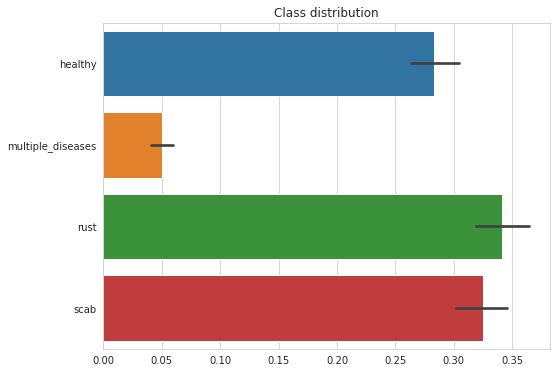

In [5]:
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(8, 6))
    sns.barplot(data=train_data, orient='h')
    plt.title('Class distribution');

# Visualize one leaf
    
Let's choose one of the leaves at random, load it and plot it. 

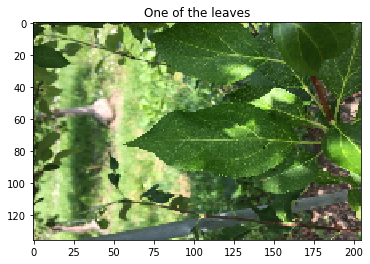

In [6]:
def load_image(image_id):
    file_path = image_id + ".jpg"
    image = cv2.imread(IMAGE_PATH + file_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Sample image from df, get its id and lot it
i = np.random.choice(train_data.index)
img_id = train_data.loc[i]['image_id']
image = load_image(img_id)

# Plot the image
plt.imshow(cv2.resize(image, (205, 136)))
plt.title('One of the leaves');

# Channel distributions
    
I will take a look at distribution of channel values, to see if some colors are more present in the pictures. For all images, I will calculate mean channel's value and plot a histogram of this means.

In [7]:
# Load images
train_images = train_data["image_id"][:SAMPLE_LEN].progress_apply(load_image)

# Calculate channel means across images
red_values = np.array([np.mean(train_images[idx][:, :, 0]) for idx in range(len(train_images))])
green_values = np.array([np.mean(train_images[idx][:, :, 1]) for idx in range(len(train_images))])
blue_values = np.array([np.mean(train_images[idx][:, :, 2]) for idx in range(len(train_images))])

# Calculate all channels means across images
values = np.array([np.mean(train_images[idx]) for idx in range(len(train_images))])

100%|██████████| 100/100 [00:08<00:00, 12.27it/s]


I will start with all channels together pixel values distribution. We can see that the distribution is close to normal, with mean around 105.

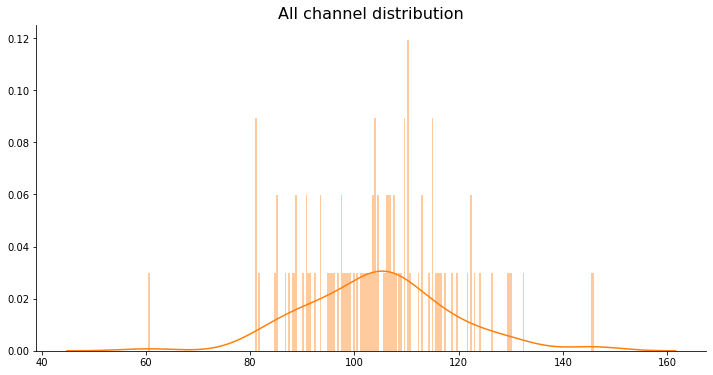

In [8]:
figure = plt.figure(figsize=(12, 6))
ax = plt.axes()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

sns.distplot(values, color='tab:orange', bins=255)
plt.title('All channel distribution', fontsize=16);

Distribution of red channel values is also close to normal, its mean is a little bit smaller, around 100.

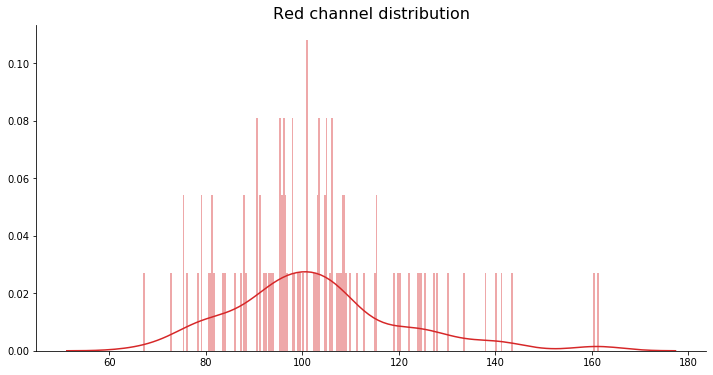

In [9]:
figure = plt.figure(figsize=(12, 6))
ax = plt.axes()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

sns.distplot(red_values, color='tab:red', bins=255)
plt.title('Red channel distribution', fontsize=16);

As we could expect, the distribution of green values is a bit different. It has higher mean, its more uniform. We can see a leftside skew.

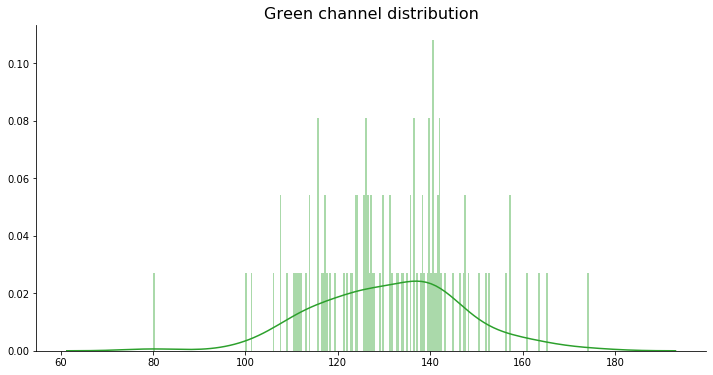

In [10]:
figure = plt.figure(figsize=(12, 6))
ax = plt.axes()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

sns.distplot(green_values, color='tab:green', bins=255)
plt.title('Green channel distribution', fontsize=16);

What looks suspicious, is that there is an image that has quite small green values. Let's check it.

In [11]:
np.argmin(green_values)

29

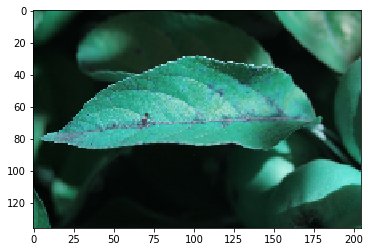

In [12]:
wierd_image = cv2.cvtColor(train_images[29], cv2.COLOR_BGR2RGB)

plt.imshow(cv2.resize(wierd_image, (205, 136)));

It turns out that the image is indeed not very green, but seems ok in general. The photo has been probably taken in bad lightning condition, using a camera that is far from ideal.

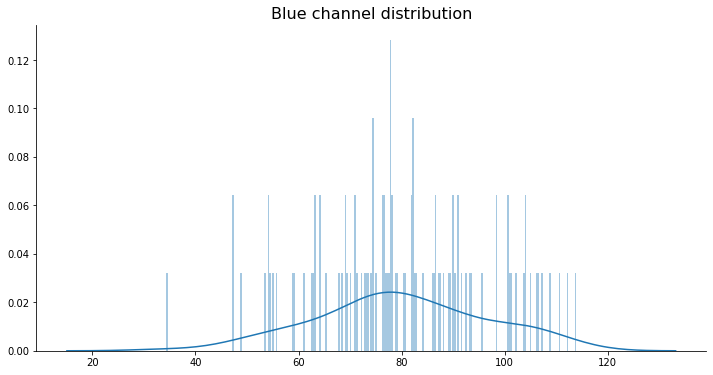

In [13]:
figure = plt.figure(figsize=(12, 6))
ax = plt.axes()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

sns.distplot(blue_values, color='tab:blue', bins=255)
plt.title('Blue channel distribution', fontsize=16);

Distribution of blue values is quite flat. There is not much blue in our pictures, the mean is a bit smaller than 80.

Let's compare the distributions next to each other.

In [14]:
df_channels = pd.DataFrame(np.concatenate([red_values[:, None], green_values[:, None], blue_values[:, None]], axis=1),
                           columns=['red', 'green', 'blue'])

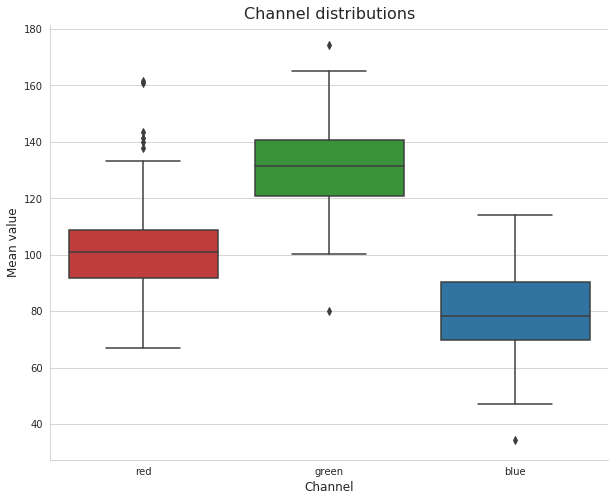

In [16]:
figure = plt.figure(figsize=(10, 8))
ax = plt.axes()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.set_style('whitegrid')

box = sns.boxplot(data=df_channels, orient='v', palette=['tab:red', 'tab:green', 'tab:blue'])
plt.title('Channel distributions', fontsize=16)
plt.xlabel('Channel', fontsize=12)
plt.ylabel('Mean value', fontsize=12);

# Healthy leaves

Enough distribution plots! Let's look at the images themselves. For each of the classes, 9 example images were chosen and plotted.

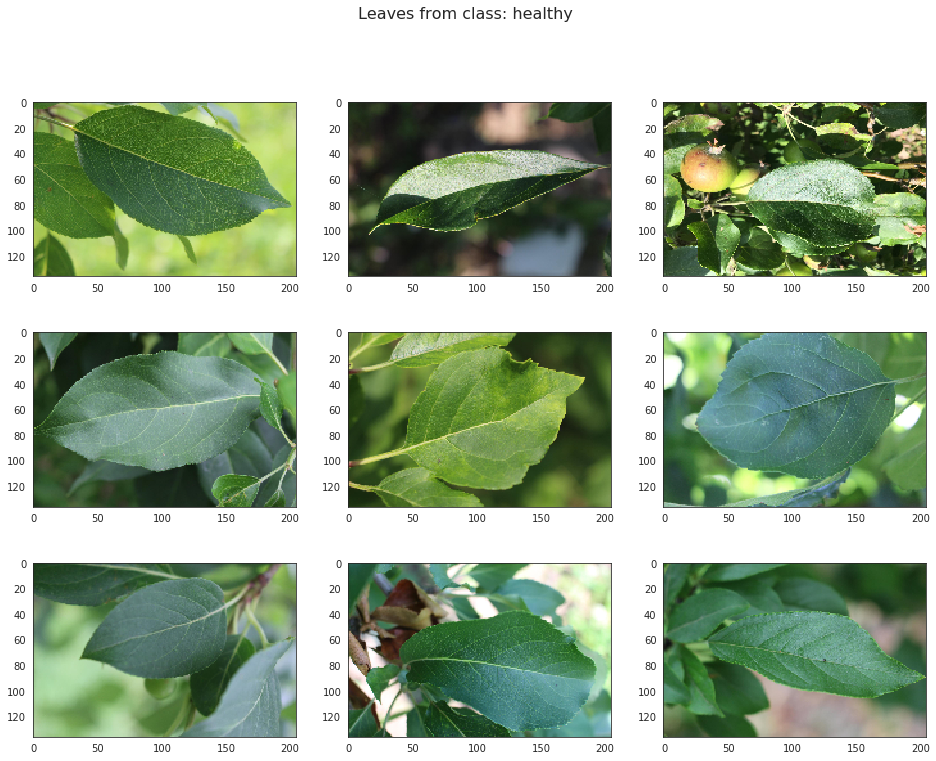

In [17]:
sns.set_style('white')

def show_leaves(leaves_class='healthy'):
    # Get subset of leaves satysfying class condition
    df_class = train_data[train_data[leaves_class]==1]
    
    # Randomly choose 9 of them
    image_ids = df_class.sample(n=9)['image_id'].values

    fig = plt.figure(figsize=(16, 12))
    
    # Plot the images one by one
    for idx, image_id in enumerate(image_ids):
        plt.subplot(3, 3, idx+1)
        image = load_image(image_id)
        plt.imshow(cv2.resize(image, (205, 136)))
    
    plt.suptitle(f'Leaves from class: {leaves_class}', fontsize=16)
    
    
show_leaves('healthy')

Healthy images look nice and clean

# Scab

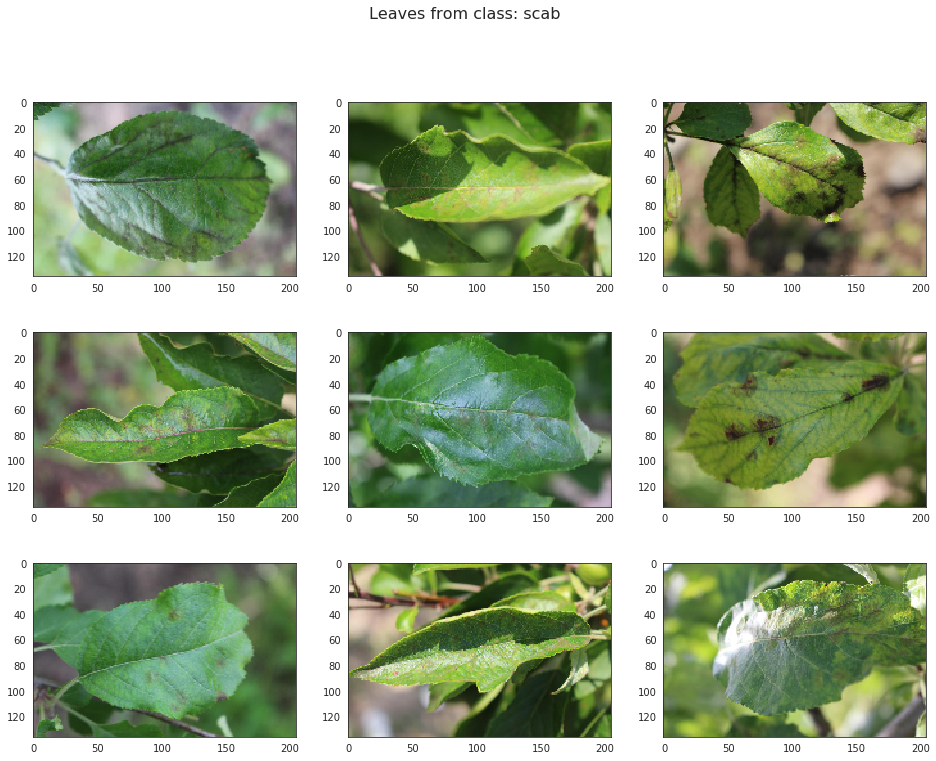

In [18]:
show_leaves('scab')

As we can see, dark marks indicate scab. Some of them are bigger, some are barely visible 

# Rust

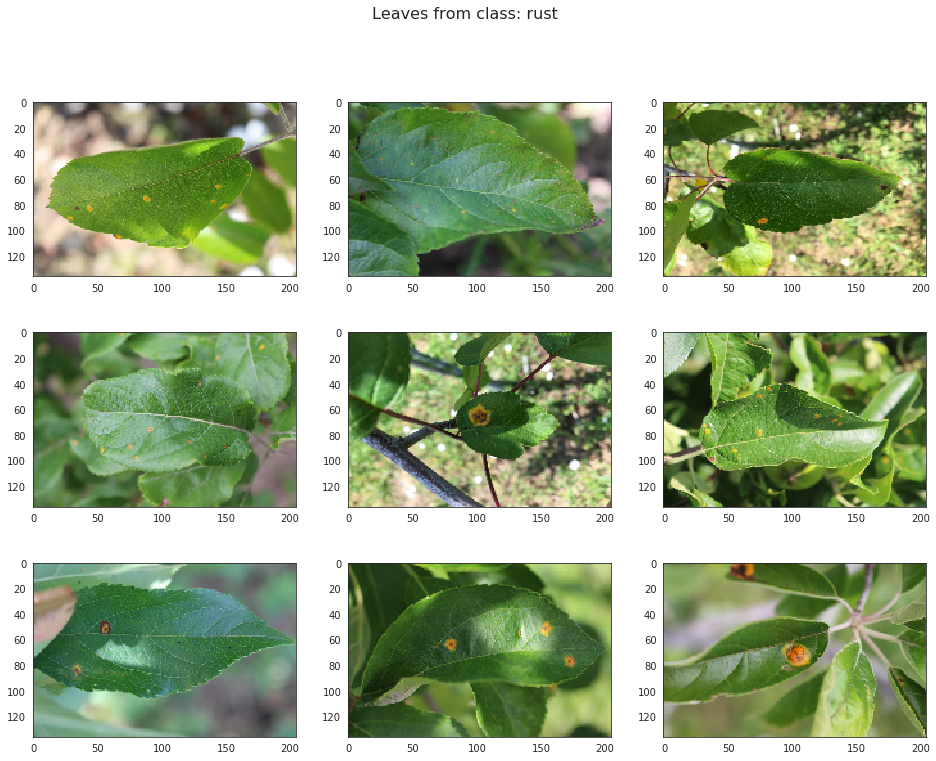

In [19]:
show_leaves('rust')

For me, rust is much easier to recognize. Orange marks are easier to capture

# Multiple diseases

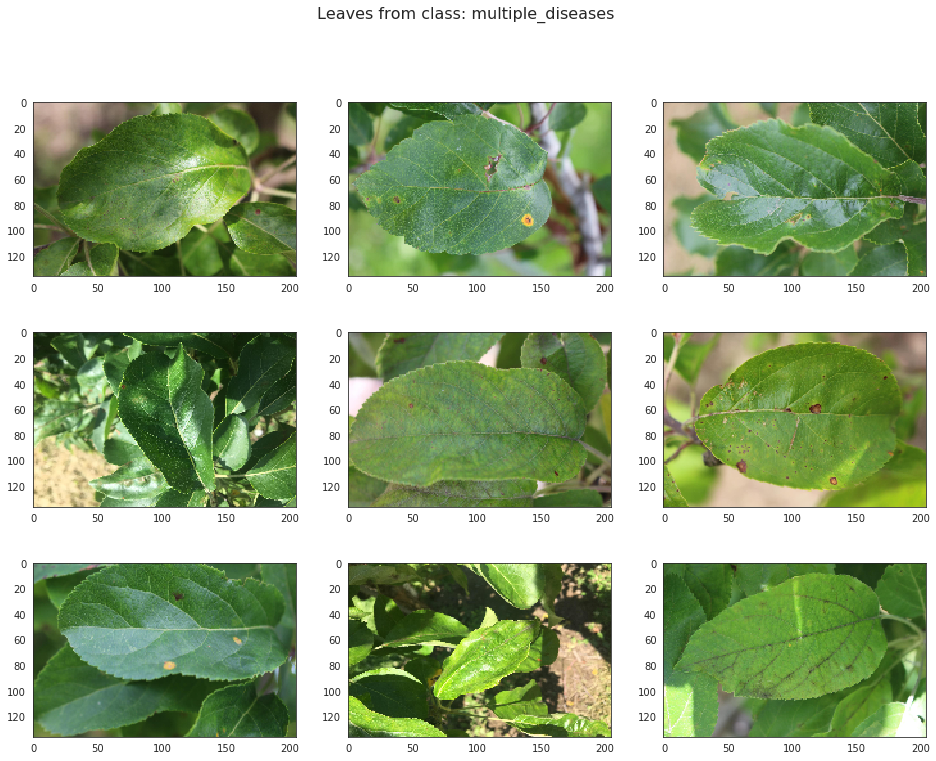

In [20]:
show_leaves('multiple_diseases')

We can see that above plots have symptoms of both scab and rust 